In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import h5py
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from GNN.inputs import  split
from scipy.optimize import curve_fit
from sklearn.metrics import confusion_matrix
from GNN.utils.cm import plot_confusion_matrix
from halotools.sim_manager import UserSuppliedHaloCatalog
from halotools.mock_observables import tpcf
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
import pandas as pd
import pickle

In [3]:
hdf5_filename = '/cosma5/data/dp004/dc-cues1/features/halo_features_s99'

with h5py.File(hdf5_filename,'r+') as feats: 
    
    mass = feats['M200c'][:]
    
    labels = feats['Ngals'][:]
    
    boxsize = feats['boxsize'].value / 1000. # to Mpc
    
    positions = feats['Pos'][:] / 1000.

    velocities = feats['Vel'][:] / 1000.

    rvir = feats['R200c'][:] / 1000.


#labels = labels > 0 

In [4]:
train_idx, test_idx, val_idx = split.train_test_val_split(len(mass),
                                                    train_size = 0.5)



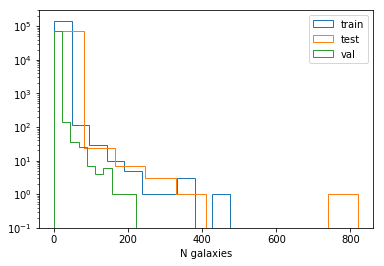

In [5]:
plt.hist(labels[train_idx], log=True, histtype='step', label = 'train')
plt.hist(labels[test_idx], log=True, histtype='step', label = 'test')
plt.hist(labels[val_idx], log=True, histtype='step', label = 'val')
plt.xlabel('N galaxies')
plt.legend()

In [6]:
train_idx, test_idx, val_idx = split.train_test_val_split(labels.shape[0],
                                        train_size = 0.5)

test_idx = np.concatenate((test_idx,val_idx))


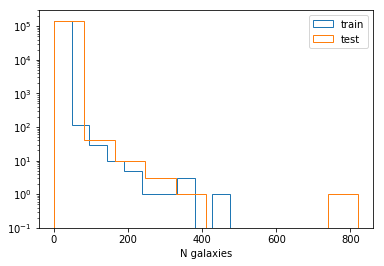

In [7]:
plt.hist(labels[train_idx], log=True, histtype='step', label = 'train')
plt.hist(labels[test_idx], log=True, histtype='step', label = 'test')
plt.xlabel('N galaxies')

plt.legend()

Text(0.5,0,'$M_{200c}$')

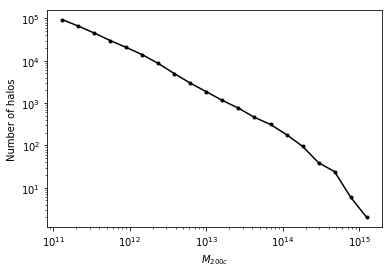

In [8]:
nbins= 20
bins = np.logspace(np.log10(np.min(mass)),
                   np.log10(np.max(mass)), nbins+1)

bin_centers = (bins[1:]+bins[:-1])/2.

mass_func, edges = np.histogram(mass, bins=bins)
plt.loglog((edges[1:]+edges[:-1])/2.,
           mass_func,color='black', marker='o',markersize=3)

plt.ylabel('Number of halos')
plt.xlabel(r'$M_{200c}$')

# Fit HOD parameters to training set

In [9]:
n_centrals = labels[train_idx] > 0
n_satellites = labels[train_idx] - 1

In [10]:
n_centrals_binned, edges, _ = binned_statistic(mass[train_idx], n_centrals, statistic = 'mean',
                                     bins=bins)

n_centrals_error, edges, _ = binned_statistic(mass[train_idx], n_centrals, statistic = 'std',
                                     bins=bins)

In [11]:
n_satellites_binned, edges, _ = binned_statistic(mass[train_idx], n_satellites, statistic = 'mean',
                                     bins=bins)

n_satellites_error, edges, _ = binned_statistic(mass[train_idx], n_satellites, statistic = 'std',
                                     bins=bins)

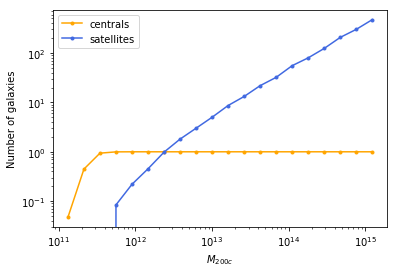

In [12]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

## Find HOD parameters

In [13]:
cen_model = Zheng07Cens()

def mean_centrals(mass, logMin, sigma_logM):

    cen_model.param_dict = {'logMmin': logMin,
                    'sigma_logM': sigma_logM}
    
    return cen_model.mean_occupation(prim_haloprop = mass)

sats_model = Zheng07Sats()

def mean_sats(mass, M0, M1, alpha):
    
    logM0 = np.log10(M0)

    logM1 = np.log10(M1)
    
    sats_model.param_dict = {'logM0': logM0, 
                'logM1': logM1, 'alpha': alpha}
    
    return sats_model.mean_occupation(prim_haloprop = mass)
    


In [14]:
popt_central, pcov_central = curve_fit(mean_centrals, bin_centers,
                      n_centrals_binned,
                    p0 = list(cen_model.param_dict.values()))

In [15]:
popt_sats, pcov_sats = curve_fit(mean_sats, bin_centers,
                      n_satellites_binned,
                    p0 =list(sats_model.param_dict.values()))

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [16]:
nbins= 30
masses = np.logspace(np.log10(np.min(mass)),
                   np.log10(np.max(mass)), nbins+1)

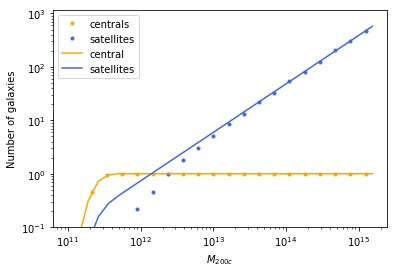

In [17]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals', linestyle='')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites', linestyle='')

cen_model.param_dict = {'logMmin':popt_central[0], 'sigma_logM': popt_central[1]}

sats_model.param_dict = {'logM0': np.log10(popt_sats[0]), 
                'logM1': np.log10(popt_sats[1]), 'alpha': popt_sats[2]}
ax.plot(masses,
           cen_model.mean_occupation(prim_haloprop = masses), #yerr = n_satellites_error, 
             color='orange',
        label = 'central')

ax.plot(masses,
          cen_model.mean_occupation(prim_haloprop = masses)*  sats_model.mean_occupation(prim_haloprop = masses) , #yerr = n_satellites_error, 
             color='royalblue',
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.ylim(1e-1)
plt.legend()

# Performance on test set

In [18]:
np.random.seed(22222)

Udf = np.random.uniform(0,1,len(test_idx))

N_mean_cen = cen_model.mean_occupation(prim_haloprop = mass[test_idx])



In [19]:
Nc_test = (N_mean_cen > Udf).astype(int)

In [20]:
cm = confusion_matrix((labels[test_idx] > 0).astype(int), Nc_test)

Normalized confusion matrix


(array([[0.85776989, 0.14223011],
        [0.14886372, 0.85113628]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x2b6169156208>)

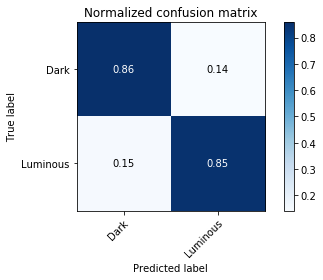

In [21]:
plot_confusion_matrix((labels[test_idx] > 0).astype(int),
    Nc_test, classes = ['Dark', 'Luminous'], 
    normalize = True)

## Two point correlation function for the test set central galaxies

In [22]:
pos_test = positions[test_idx, :].clip(0.)

pos_test_galaxies = pos_test[labels[test_idx] > 0]

r = np.geomspace(0.3, 10., 20)

test_tpcf = tpcf(pos_test_galaxies, rbins = r, period = boxsize, estimator =  'Landy-Szalay' )

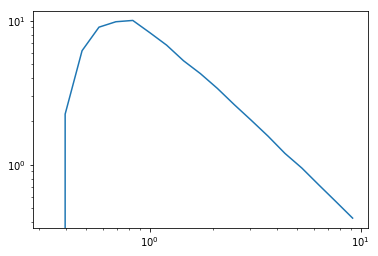

In [23]:
r_c = 0.5 * (r[1:] + r[:-1])
plt.loglog(r_c, test_tpcf)

## Populate halo catalog

In [24]:
halocat = UserSuppliedHaloCatalog( redshift = 0., Lbox = boxsize, 
        halo_x = positions[:, 0].clip(0), halo_y = positions[:, 1], halo_z = positions[:, 2],
        halo_vx = velocities[:,0], halo_vy = velocities[:,1], halo_vz = velocities[:,2],
        halo_mvir = mass, halo_id = np.arange(mass.shape[0]), halo_hostid = np.arange(mass.shape[0]),
        particle_mass = 1e9, halo_upid = -1. * np.ones_like(mass),
        halo_rvir = rvir
        )

In [25]:
cens_prof_model = TrivialPhaseSpace()

In [26]:
#sats_prof_model = TrivialPhaseSpace()

In [27]:
model_instance = HodModelFactory(
    centrals_occupation = cen_model,
    centrals_profile = cens_prof_model)

In [28]:
model_instance.populate_mock(halocat)

In [29]:
type(model_instance.mock.galaxy_table)

astropy.table.table.Table

In [30]:
df_mock = pd.DataFrame(np.array(model_instance.mock.galaxy_table))

In [31]:
len(df_mock)

114372

In [32]:
df_mock_test = df_mock[df_mock['halo_id'].isin(test_idx)]

In [33]:
len(df_mock_test)

57157

In [34]:
pos_test_mock = np.vstack([df_mock_test['x'], 
                           df_mock_test['y'],
                           df_mock_test['z']]
                         ).T

In [35]:
pos_test_mock.shape

(57157, 3)

In [36]:
#r, clustering = model_instance.mock.compute_galaxy_clustering(gal_type = 'centrals') 

mock_tpcf = tpcf(pos_test_mock, rbins = r, period = boxsize, estimator =  'Landy-Szalay' )

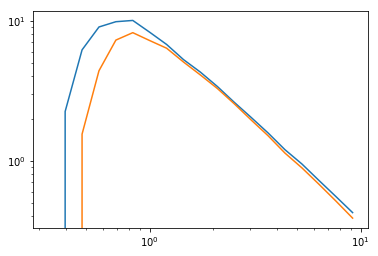

In [37]:
plt.loglog(r_c, test_tpcf)
plt.loglog(r_c, mock_tpcf)

(0.8, 1.2)

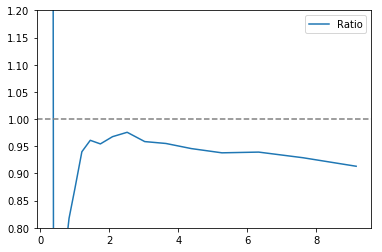

In [39]:
plt.plot(r_c, mock_tpcf/test_tpcf, label = 'Ratio')
plt.axhline(y = 1., color='gray', linestyle='dashed')
plt.legend()
plt.ylim(0.8,1.2)

In [40]:
hod_tpcf_dict = {
        'r_c': r_c,
        'tpcf': mock_tpcf,
                }

In [42]:
with open('hod_tpcf.pkl', 'wb') as f:
    pickle.dump(hod_tpcf_dict, f)